## Extended Assignment 1 - Optimising Decision Tree Classifiers using Hyper parameter Tuning


Created on Friday Jan 27

@author: Abhishek Shankar, Abhishek Jaiswal, Devesh Surve


The Input dataset is data extracted from weather stations around Lake Michigan, We have compiled all 3 datasets from NOAA into a single dataframe. 

## Importing required packages

In [1]:
import os
from pprint import pprint
import pandas as pd
import numpy as np 
from collections import Counter
import dateutil
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
wd = os.getcwd()

## Reading data

In [2]:
data = pd.DataFrame()
for files in os.listdir():
    if ((files.endswith(".csv")) & ("2013" in files)):
        f1 = pd.read_csv(files)
        data = pd.concat([data,f1])

print(len(data))

13106


# Data Preprocessing 

## Removing columns which are not required

In [3]:
df = data.copy()
df.columns = ["LES_Cloud_Exists" if x=='LES_Exist' else x for x in df.columns ]
df = df[[x for x in df.columns if (('time' not in x.lower()))]]
df = df[[x for x in df.columns if (('utc' not in x.lower()))]]
df = df[[x for x in df.columns if (('cst' not in x.lower()))]]


## Removing NaN values and replacing N and Y with 0 and 1
All columns are converted to numeric data types. After initial preprocessing of the dataset we perform some EDA to check the NaN values and the need for imputing values.

In [4]:
df.iloc[:,-1] = np.where(df.iloc[:,-1].astype(str).str.lower()=='y',1,0)
df.iloc[:,-2] = np.where(df.iloc[:,-2].astype(str).str.lower()=='y',1,0)

df.iloc[:,1:] = df.iloc[:,1:].apply(lambda x : pd.to_numeric(x , errors = 'coerce'))
df = df.dropna(axis=1, how='all')
df = df.dropna(axis=0, subset=['Date'])
df.head()
df['Precip (in)'] = pd.to_numeric(df['Precip (in)'],errors ='coerce')
df['Temp (F)'] = pd.to_numeric(df['Temp (F)'], errors = 'coerce')

df['LESnowfall'] = np.where(((df['Precip (in)'] > 0) & (df['Temp (F)'] <= 32)),1,0)
print("###### Count of LESnowfall ######")
print(len(df[df["LESnowfall"]==0]))
print(len(df[df["LESnowfall"]==1]))
print("###### Percentage of NaN ######")
print(df.isnull().sum().sort_values(ascending=False) * 100 / len(df))

###### Count of LESnowfall ######
12517
577
###### Percentage of NaN ######
Heat Index (F)          99.977089
High Cloud Ht (ft)      90.476554
Peak Wind Gust(mph)     80.326867
Med Cloud Ht (ft)       67.908966
Wind Chill (F)          24.392852
Low Cloud Ht (ft)       21.857339
Sea Lev Press (hPa)      6.231862
Precip (in)              4.712082
Centroid_lon             0.893539
Centroid_lat             0.893539
Kurtosis_lat             0.893539
Kurtosis_lon             0.893539
Skewness_lat             0.893539
Skewness_lon             0.893539
Std_lat                  0.893539
Std_lon                  0.893539
Sample Number            0.893539
Mean                     0.893539
Wind Direction (deg)     0.649152
RH (%)                   0.626241
Dewpt (F)                0.626241
Temp (F)                 0.542233
Wind Spd (mph)           0.198564
Atm Press (hPa)          0.122193
Visibility (mi)          0.061097
LES_Cloud_Exists         0.000000
Date                     0.000000
Lake_V

## Imputing Values for NaNs
Based on the following criteria NaNs are dropped or imputed with the mean value of the column.

1. Columns with NaNs > 30 % are dropped
2. Columns with NaNs > 1% and < 30% are imputed
3. Rows from columns containing NaNs < 1% are dropped.

In [5]:
drop = pd.DataFrame(df.isnull().sum().sort_values(ascending=False) * 100 / len(df)).reset_index()
cols = drop[drop.iloc[:,-1] > 30].iloc[:,0].to_list()
df = df[[x for x in df.columns if x not in cols]]
nancols = drop[((drop.iloc[:,-1] > 1) & (drop.iloc[:,-1] < 30)) ].iloc[:,0].to_list()
values = df.filter(nancols).mean()
df[nancols]=df[nancols].fillna(value = values.iloc[0])
print(df.isnull().sum().sort_values(ascending=False) * 100 / len(df))
df = df.dropna(axis=0)
print("###### Percentage of NaN After Cleaning up ######")
print(df.isnull().sum().sort_values(ascending=False) * 100 / len(df))
df.to_csv(wd+"/Pythoncode/Input_Dataset.csv",index=False)

Mean                    0.893539
Kurtosis_lon            0.893539
Skewness_lon            0.893539
Std_lat                 0.893539
Std_lon                 0.893539
Centroid_lat            0.893539
Centroid_lon            0.893539
Kurtosis_lat            0.893539
Sample Number           0.893539
Skewness_lat            0.893539
Wind Direction (deg)    0.649152
Dewpt (F)               0.626241
RH (%)                  0.626241
Temp (F)                0.542233
Wind Spd (mph)          0.198564
Atm Press (hPa)         0.122193
Visibility (mi)         0.061097
LES_Cloud_Exists        0.000000
Lake_Visible            0.000000
Date                    0.000000
Wind Chill (F)          0.000000
Precip (in)             0.000000
Sea Lev Press (hPa)     0.000000
Low Cloud Ht (ft)       0.000000
LESnowfall              0.000000
dtype: float64
###### Percentage of NaN After Cleaning up ######
Date                    0.0
Centroid_lon            0.0
LES_Cloud_Exists        0.0
Lake_Visible            0.

In [6]:
print(len(df[df["LESnowfall"]==0]))
print(len(df[df["LESnowfall"]==1]))

12226
574


## Adding simple ML library to python path

In [7]:

sys.path.append(wd+'/Pythoncode/')

import simple_ml

e_data = df.iloc[:,1:].values.tolist()
import simple_ml

## Calculating the entropy for the target column

In [8]:
simple_ml.entropy(e_data, -1, "LESSnow")

entropy(LESSnow) = 
  - p(0.0) x log(p(0.0), 2)  =  - 0.955 x log(0.955)  =  -0.063
  - p(1.0) x log(p(1.0), 2)  =  - 0.045 x log(0.045)  =  -0.201
  = 0.264


0.2640759512130957

In [9]:
attribute_names = list(df.columns[1:])
e_data = df.iloc[:,1:].values.tolist()

for i in zip(attribute_names, e_data[0]):
    print(i)

('Temp (F)', 63.0)
('RH (%)', 80.0)
('Dewpt (F)', 57.0)
('Wind Spd (mph)', 10.0)
('Wind Direction (deg)', 210.0)
('Low Cloud Ht (ft)', 15.684646464646464)
('Visibility (mi)', 10.0)
('Atm Press (hPa)', 988.1)
('Sea Lev Press (hPa)', 1012.4)
('Precip (in)', 0.0)
('Wind Chill (F)', 15.684646464646464)
('Mean', 0.002174504)
('Centroid_lon', -86.72815026)
('Centroid_lat', 43.94443176)
('Std_lon', 0.670232465)
('Std_lat', 1.239065248)
('Skewness_lon', 0.660356987)
('Skewness_lat', 0.030174609)
('Kurtosis_lon', 2.863913)
('Kurtosis_lat', 1.68989867)
('Sample Number', 4.0)
('Lake_Visible', 0.0)
('LES_Cloud_Exists', 0.0)
('LESnowfall', 0.0)


## Calculating the entropy for all columns

In [10]:
print('Information gain for different attributes:', end='\n\n')
sorted_information_gain_indexes = sorted([(simple_ml.information_gain(e_data, i, 23), i)
                                          for i in range(0, len(attribute_names)-1)], 
                                         reverse=True)
for gain, i in sorted_information_gain_indexes:
    print('{:5.3f}  {:2} {}'.format(gain, i, attribute_names[i]))
    
len(sorted_information_gain_indexes)

Information gain for different attributes:

0.221  19 Kurtosis_lat
0.221  18 Kurtosis_lon
0.221  17 Skewness_lat
0.221  16 Skewness_lon
0.221  15 Std_lat
0.221  14 Std_lon
0.221  13 Centroid_lat
0.221  12 Centroid_lon
0.221  11 Mean
0.191   9 Precip (in)
0.111   6 Visibility (mi)
0.063   5 Low Cloud Ht (ft)
0.047   0 Temp (F)
0.045   1 RH (%)
0.034  10 Wind Chill (F)
0.032   2 Dewpt (F)
0.031   8 Sea Lev Press (hPa)
0.026   7 Atm Press (hPa)
0.020   4 Wind Direction (deg)
0.003   3 Wind Spd (mph)
0.000  22 LES_Cloud_Exists
0.000  20 Sample Number
0.000  21 Lake_Visible


23

In [11]:
# info_gain = sorted(['{:5.3f}  {:2} {}'.format(simple_ml.information_gain(e_data, i, 18), i, values) for i,values in enumerate(df.columns[1:])], reverse = True)
info_gain = ['{:5.3f}  {:2} {}'.format(simple_ml.information_gain(e_data, i, 23), i, values) for i,values in enumerate(df.columns[1:])]
info_gain

['0.047   0 Temp (F)',
 '0.045   1 RH (%)',
 '0.032   2 Dewpt (F)',
 '0.003   3 Wind Spd (mph)',
 '0.020   4 Wind Direction (deg)',
 '0.063   5 Low Cloud Ht (ft)',
 '0.111   6 Visibility (mi)',
 '0.026   7 Atm Press (hPa)',
 '0.031   8 Sea Lev Press (hPa)',
 '0.191   9 Precip (in)',
 '0.034  10 Wind Chill (F)',
 '0.221  11 Mean',
 '0.221  12 Centroid_lon',
 '0.221  13 Centroid_lat',
 '0.221  14 Std_lon',
 '0.221  15 Std_lat',
 '0.221  16 Skewness_lon',
 '0.221  17 Skewness_lat',
 '0.221  18 Kurtosis_lon',
 '0.221  19 Kurtosis_lat',
 '0.000  20 Sample Number',
 '0.000  21 Lake_Visible',
 '0.000  22 LES_Cloud_Exists',
 '0.264  23 LESnowfall']

## Prof Dino's Simple ML function modified for current dataset

Since, the dataset have numerical values only, it makes more sense to update function 'split_instances' under the simple_ml file  which was originally designed with respect to categorical features.<br><br>
In brief, this function helps us create partitions of dataset which helps in forming branching nodes(or the decision nodes) of the tree. Like based on specific value the branch will go to either left child node or right child node.<br>

In [12]:
from collections import defaultdict

def split_instances(instances, attribute_index):
    '''Returns a list of dictionaries, splitting a list of instances 
        according to their values of a specified attribute index
    
    The key of each dictionary is a distinct value of attribute_index,
    and the value of each dictionary is a list representing 
       the subset of instances that have that value for the attribute
    '''
    partitions = defaultdict(list)
    for instance in instances:
        partitions[instance[attribute_index]].append(instance)
    return partitions

Above is the split_instances function designed by professor to perform branching. We have modified this function to incorporate the branching of attributes based on their continous values. 

In [13]:
def split_instances(instances, attribute_index, colnames):
    '''Returns a list of dictionaries, splitting a list of instances 
        according to their values of a specified attribute index

    The key of each dictionary is a distinct value of attribute_index,
    anda= the value of each dictionary is a list representing 
       the subset of instances that have that value for the attribute
    '''
    partitions = defaultdict(list)
    colnames = list(pd.read_csv("Input_Dataset.csv").columns)
    final_df = pd.DataFrame(instances,columns=colnames[1:-1])

    col_name = final_df.columns[attribute_index]
    print(col_name)
    
    if len(final_df[col_name].value_counts()) > 4:
        mini,maxi = min(final_df[col_name]),max(final_df[col_name])
        n = len(final_df)//10  #chunk row size
        test = final_df.sort_values(by=[col_name])
        # import pdb;pdb.set_trace()
        if n == 0:
            index = col_name + 'last'
            partitions[index] = test.values.tolist()
        elif len(test[col_name].value_counts()) < 4:
            for partition in final_df[col_name].unique():
                ls = final_df.loc[(final_df[col_name] == partition)].values.tolist()
                index = col_name + f'{partition}'
                partitions[index] = (ls)            
        else:
            for i in range(0,test.shape[0],n):
                # list_df = [test[i:i+n] ]
                a,b = min(test[i:i+n][col_name]),max(test[i:i+n][col_name])
                index = col_name + f'{a} to {b}'
                partitions[index]=test[i:i+n].values.tolist()
    else:
        ## partitioning using unique values
        for partition in final_df[col_name].unique():
            ls = final_df.loc[(final_df[col_name] == partition)].values.tolist()
            index = col_name + f'{partition}'
            partitions[index] = (ls)            

    return partitions

In the modified code above, we are partitioning the continous attributes by dividing them into 10 bins of equal length. Whereas for columns which have less than or equal to 4 unique values, the partitioning is performed using professor's code.

### Running the create_decision_tree function with modified split_instances function. 

In [14]:
x =[i[:-1] for i in e_data] 
y= [i[-1] for i in e_data]
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)
training_instances = []
test_instances = []
for i,j in zip(list(X_train),list(y_train)):
    list(i).append(j)
    training_instances.append(list(i))
for i,j in zip(list(X_test),list(y_test)):
    list(i).append(j)
    test_instances.append(list(i))

In [15]:
dict()

{}

In [16]:
import simple_ml as sm
tree = sm.create_decision_tree(training_instances, trace=1, class_index=-1)  # remove trace=1 to turn off tracing

class -1
> Creating tree node for attribute index 0
best_index 0
Temp (F)
> Creating subtree for value Temp (F)-16.0 to 9.0 (960, 22, -1, 0.0)
class -1
> > Creating tree node for attribute index 19
best_index 19
Kurtosis_lat
> > Creating subtree for value Kurtosis_lat1.533421540956232 to 1.6615799954304582 (96, 21, -1, 0.0)
class -1
> > > Creating tree node for attribute index 18
best_index 18
Kurtosis_lon
> > > Creating subtree for value Kurtosis_lon2.537613014 to 2.5996764532653835 (9, 20, -1, 0.0)
class -1
< < < < All 9 instances have label 0.0
> > > Creating subtree for value Kurtosis_lon2.5996764532653835 to 2.7572305298012463 (9, 20, -1, 0.0)
class -1
< < < < All 9 instances have label 0.0
> > > Creating subtree for value Kurtosis_lon2.757776674 to 2.776643931261824 (9, 20, -1, 0.0)
class -1
< < < < All 9 instances have label 0.0
> > > Creating subtree for value Kurtosis_lon2.7854147715364306 to 2.8162355991807204 (9, 20, -1, 0.0)
class -1
> > > > Creating tree node for attribute

Sea Lev Press (hPa)
> > > > Creating subtree for value Sea Lev Press (hPa)last (9, 19, -1, 0.0)
class -1
> > > > > Creating tree node for attribute index 1
best_index 1
RH (%)
> > > > > Creating subtree for value RH (%)last (9, 18, -1, 0.0)
class -1
> > > > > > Creating tree node for attribute index 10
best_index 10
Wind Chill (F)
> > > > > > Creating subtree for value Wind Chill (F)last (9, 17, -1, 0.0)
class -1
> > > > > > > Creating tree node for attribute index 17
best_index 17
Skewness_lat
> > > > > > > Creating subtree for value Skewness_latlast (9, 16, -1, 0.0)
class -1
> > > > > > > > Creating tree node for attribute index 16
best_index 16
Skewness_lon
> > > > > > > > Creating subtree for value Skewness_lonlast (9, 15, -1, 0.0)
class -1
> > > > > > > > > Creating tree node for attribute index 15
best_index 15
Std_lat
> > > > > > > > > Creating subtree for value Std_latlast (9, 14, -1, 0.0)
class -1
> > > > > > > > > > Creating tree node for attribute index 14
best_index 14
Std_

In [17]:
pprint(tree)

{0: {'Temp (F)-16.0 to 9.0': {19: {'Kurtosis_lat1.533421540956232 to 1.6615799954304582': {18: {'Kurtosis_lon2.537613014 to 2.5996764532653835': 0.0,
                                                                                                'Kurtosis_lon2.5996764532653835 to 2.7572305298012463': 0.0,
                                                                                                'Kurtosis_lon2.757776674 to 2.776643931261824': 0.0,
                                                                                                'Kurtosis_lon2.7854147715364306 to 2.8162355991807204': {17: {'Skewness_latlast': {16: {'Skewness_lonlast': {15: {'Std_latlast': {14: {'Std_lonlast': {13: {'Centroid_latlast': {12: {'Centroid_lonlast': {11: {'Meanlast': {10: {'Wind Chill (F)last': {8: {'Sea Lev Press (hPa)last': {5: {'Low Cloud Ht (ft)last': {4: {'Wind Direction (deg)last': {2: {'Dewpt (F)last': {7: {'Atm Press (hPa)last': {1: {'RH (%)last': {3: {'Wind Spd (mph)last': {20: {'Sa

In [18]:
def classify(tree, instance, default_class=None):
    '''Returns a classification label for instance, given a decision tree'''
    if not tree: # if the node is empty, return the default class
        return default_class
    if not isinstance(tree, dict): # if the node is a leaf, return its class label
        return tree
    attribute_index = list(tree.keys())[0] # using list(dict.keys()) for Python 3 compatibility
    attribute_values = list(tree.values())[0]
    instance_attribute_value = instance[attribute_index]
    if instance_attribute_value not in attribute_values: # this value was not in training data
        return default_class
    # recursively traverse the subtree (branch) associated with instance_attribute_value
    return classify(attribute_values[instance_attribute_value], instance, default_class)

# for instance in test_instances:
#     predicted_label = classify(tree, instance)
#     actual_label = instance[0]
#     print('predicted: {}; actual: {}'.format(predicted_label, actual_label))

def classification_accuracy(tree, test_instances, class_index=0, default_class=None):
    '''Returns the accuracy of classifying test_instances with tree,
    where the class label is in position class_index'''
    num_correct = 0
    for i in range(len(test_instances)):
        prediction = classify(tree, test_instances[i], default_class)
        actual_value = test_instances[i][class_index]
        if prediction == actual_value:
            num_correct += 1
    return num_correct / len(test_instances)

print(classification_accuracy(tree, test_instances))

0.0


- As, we can see, even after devising an apt-method to partition the continous attributes. We aren't able to build an accurate decision tree using this methodology.<br><br>
- We are alos thinking of modifying the classify function with respect to our trained Decision tree. As we are not sure, if it is able to traverse through each decision node based on partition logic and may get stuck in the middle of the tree with nowhere to go<br><br>
- The primary reason being, the decision tree is training way too much on the training data which is evident from the depth of our decision tree created. Hence, the model is overfitting the training data. Also, the dataset is highly imbalanced hence the training for one specific category results in very deep decision tree.

# We continue our analysis of the dataset using Sklearn

## Splitting Data to train and test

In [19]:
ss = ['Temp (F)',
 'RH (%)',
 'Dewpt (F)',
 'Wind Spd (mph)',
 'Wind Direction (deg)',
 'Low Cloud Ht (ft)',
 'Visibility (mi)',
 'Atm Press (hPa)',
 'Sea Lev Press (hPa)',
 'Precip (in)',
 'Wind Chill (F)',
 'Mean',
 'Centroid_lon',
 'Centroid_lat',
 'Std_lon',
 'Std_lat',
 'Skewness_lon',
 'Skewness_lat',
 'Kurtosis_lon',
 'Kurtosis_lat',
 'Sample Number',
 'Lake_Visible',
 'LES_Cloud_Exists']
[i.replace(" ","_").lower() for i in ss]

['temp_(f)',
 'rh_(%)',
 'dewpt_(f)',
 'wind_spd_(mph)',
 'wind_direction_(deg)',
 'low_cloud_ht_(ft)',
 'visibility_(mi)',
 'atm_press_(hpa)',
 'sea_lev_press_(hpa)',
 'precip_(in)',
 'wind_chill_(f)',
 'mean',
 'centroid_lon',
 'centroid_lat',
 'std_lon',
 'std_lat',
 'skewness_lon',
 'skewness_lat',
 'kurtosis_lon',
 'kurtosis_lat',
 'sample_number',
 'lake_visible',
 'les_cloud_exists']

In [20]:
data_sklearn = df.copy()
X = data_sklearn.iloc[:,1:-1]
y = data_sklearn.iloc[:,-1]
print(y)

1       0
2       0
3       0
4       0
5       0
       ..
4358    0
4359    0
4360    0
4361    0
4362    0
Name: LESnowfall, Length: 12800, dtype: int32


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Applying a Decision Tree Classifier on the dataset 

In [22]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

## Analysing the metrics of the model

In [23]:
y_pred = model.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print('Testing Set Evaluation F1-Score:',f1_score(y_test,y_pred))
print("Area under curve is : ",roc_auc)

R^2 :  1.0
MAE : 0.0
RMSE: 0.0
Testing Set Evaluation F1-Score: 1.0
Area under curve is :  1.0


## Plotting the tree for the decision tree classifier

In [24]:
export_graphviz(model, 'tree.dot', feature_names = list(X.columns))

'dot' is not recognized as an internal or external command,
operable program or batch file.


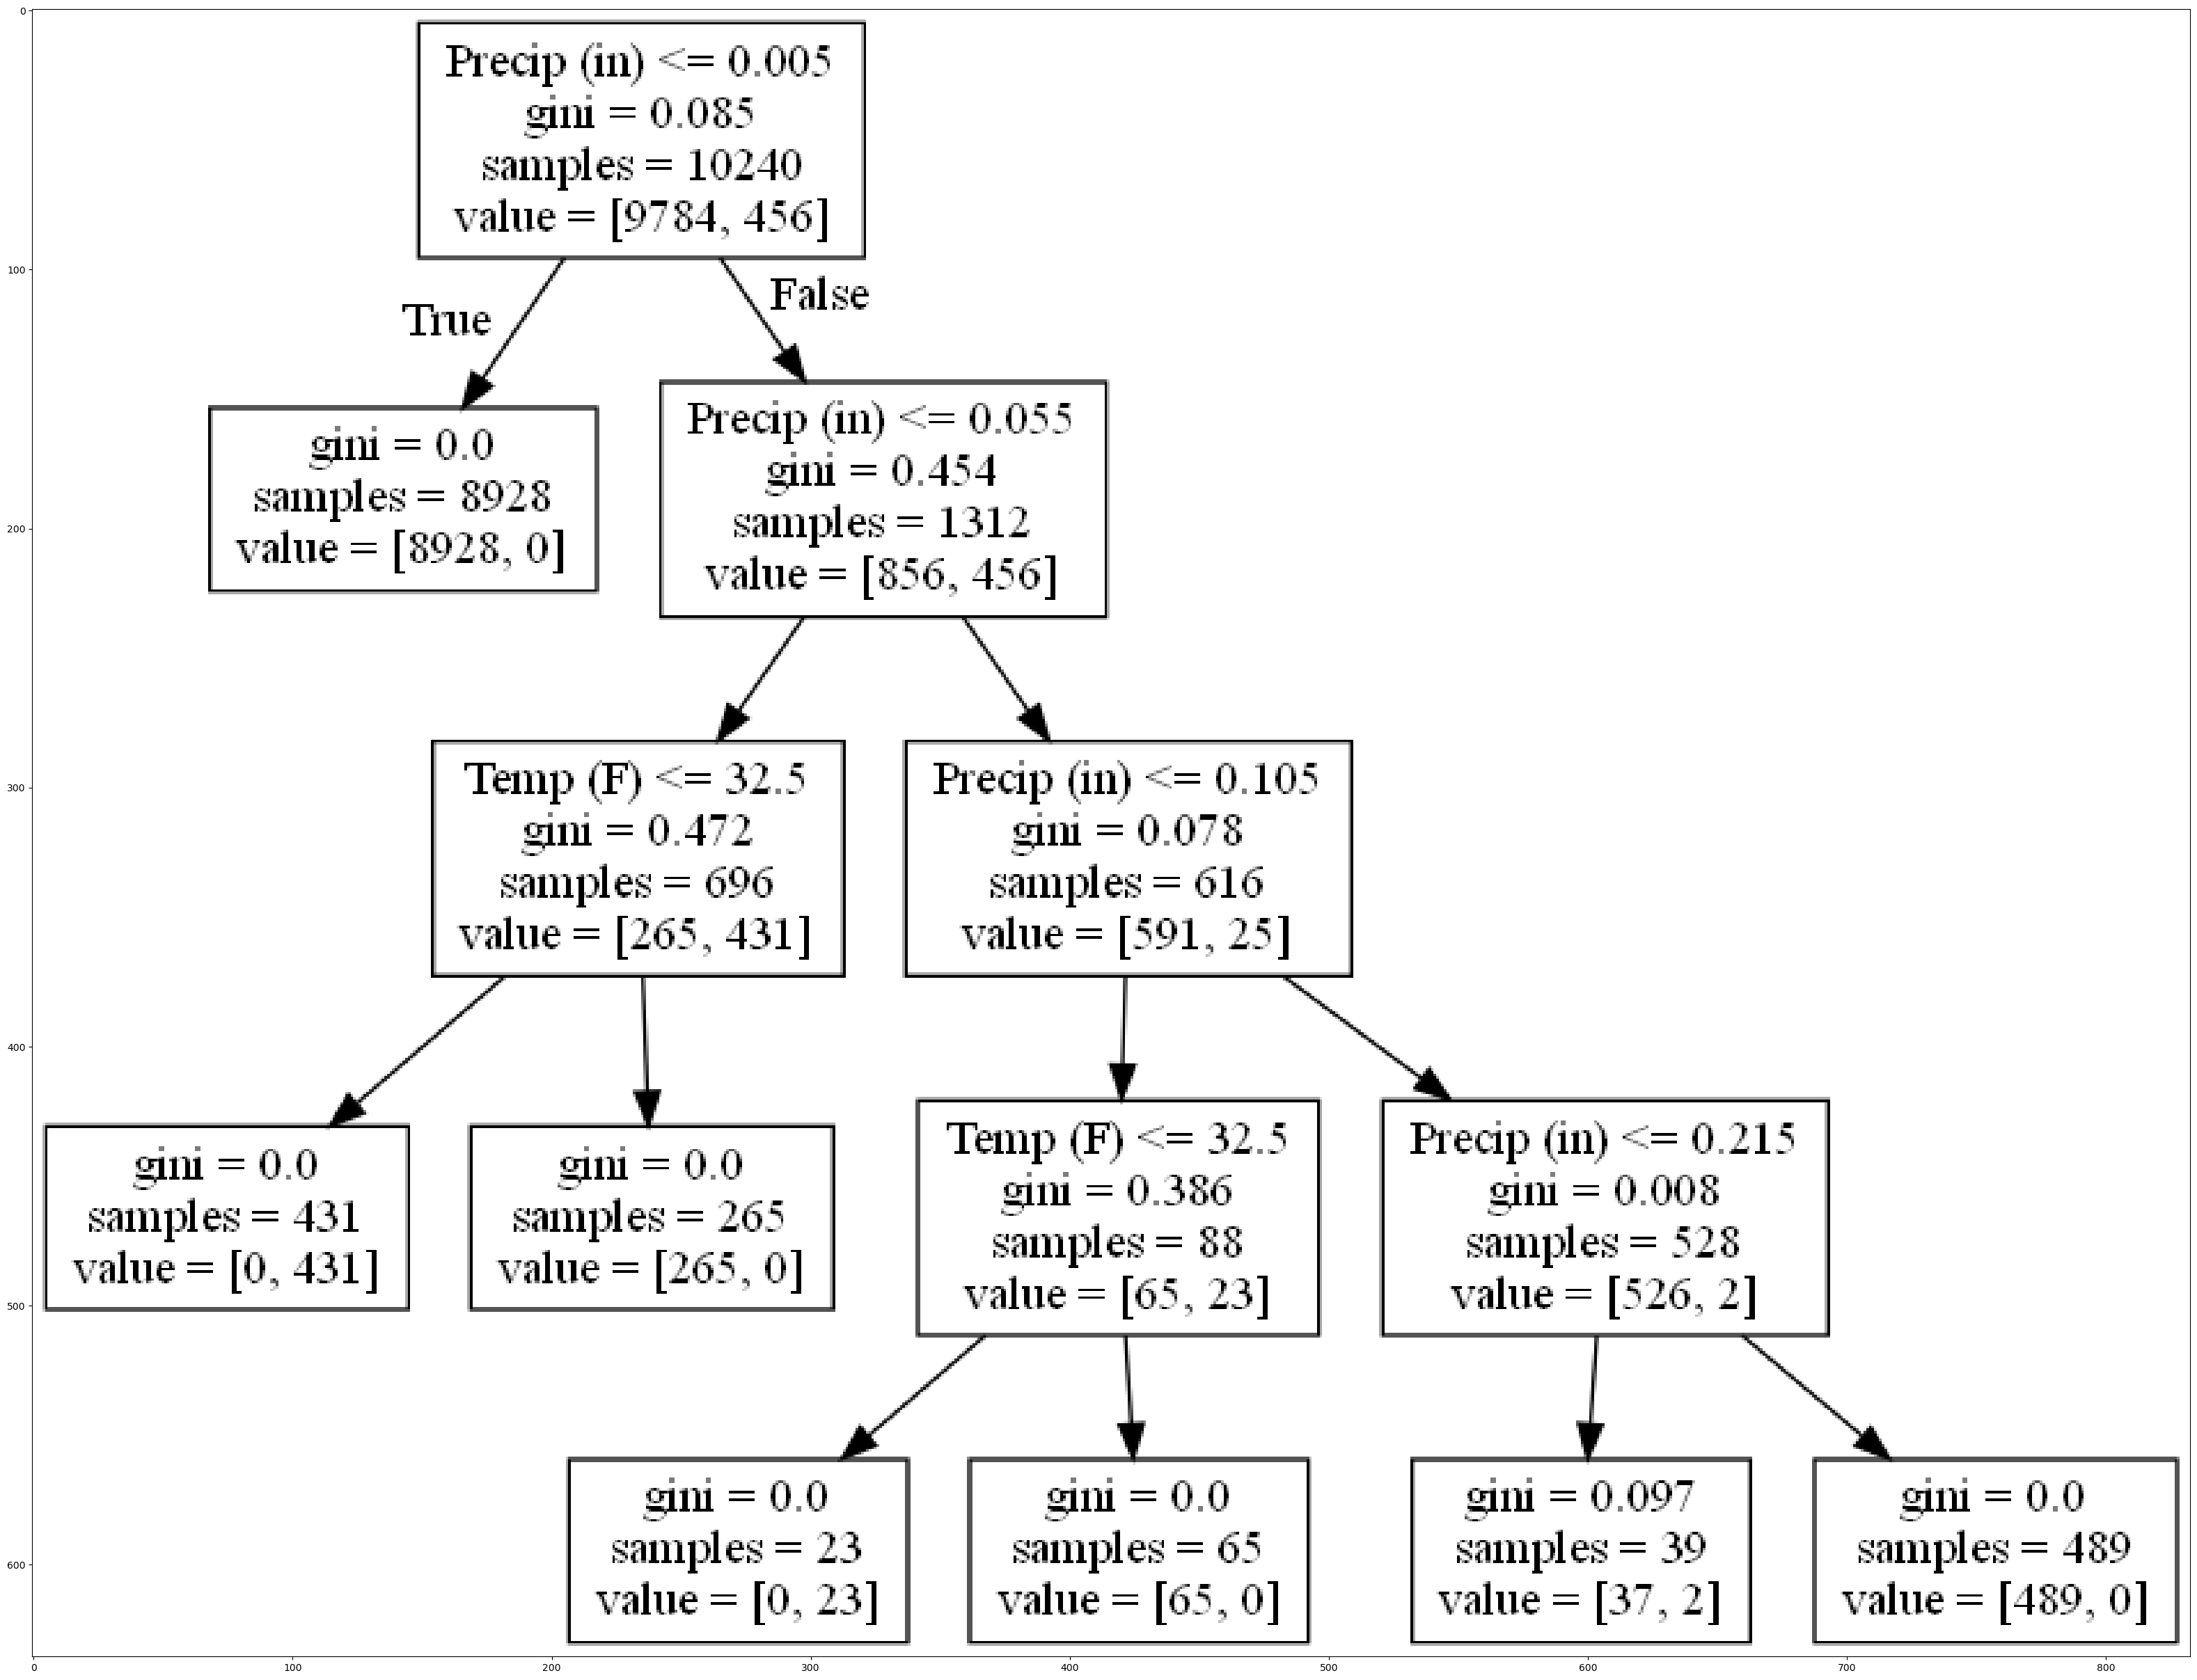

In [25]:
!dot -Tpng tree.dot -o tree.png
img = cv2.imread('tree.png')
plt.figure(figsize = (40, 40))
plt.imshow(img)

In [26]:
# list(X.columns)

In [27]:
dot_data = export_graphviz(model, out_file=None, 
                      feature_names=list(X.columns),  
                      class_names=["Yes","No"],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

## Applying a Random Forest Classifier on the dataset
The metrics of this model are analysed

In [28]:

rfc_model = RandomForestClassifier()
rfc_model.fit(X_train, y_train)

# Evaluating on Training set
train = rfc_model.predict(X_train)
print('Training Set Evaluation F1-Score :',f1_score(y_train,train))

test = rfc_model.predict(X_test)
print('Testing Set Evaluation F1-Score :',f1_score(y_test,test))


false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print("Area under curve is : ", roc_auc)

Training Set Evaluation F1-Score : 1.0
Testing Set Evaluation F1-Score : 0.9827586206896551
Area under curve is :  1.0


## Comparing feature importance of each model

In [29]:
feature_importance=pd.DataFrame({
    'Random_Forest':rfc_model.feature_importances_,
    'dt':model.feature_importances_
})
print(feature_importance)

    Random_Forest        dt
0        0.067003  0.419992
1        0.029543  0.000000
2        0.053563  0.000000
3        0.011160  0.000000
4        0.022184  0.000000
5        0.029800  0.000000
6        0.145224  0.000000
7        0.017520  0.000000
8        0.078141  0.000000
9        0.428671  0.580008
10       0.021327  0.000000
11       0.012050  0.000000
12       0.011025  0.000000
13       0.009623  0.000000
14       0.009643  0.000000
15       0.009238  0.000000
16       0.010502  0.000000
17       0.008932  0.000000
18       0.009554  0.000000
19       0.008365  0.000000
20       0.002473  0.000000
21       0.002549  0.000000
22       0.001909  0.000000


# Plotting the Comparison of features between Random Forest and Decision Trees 

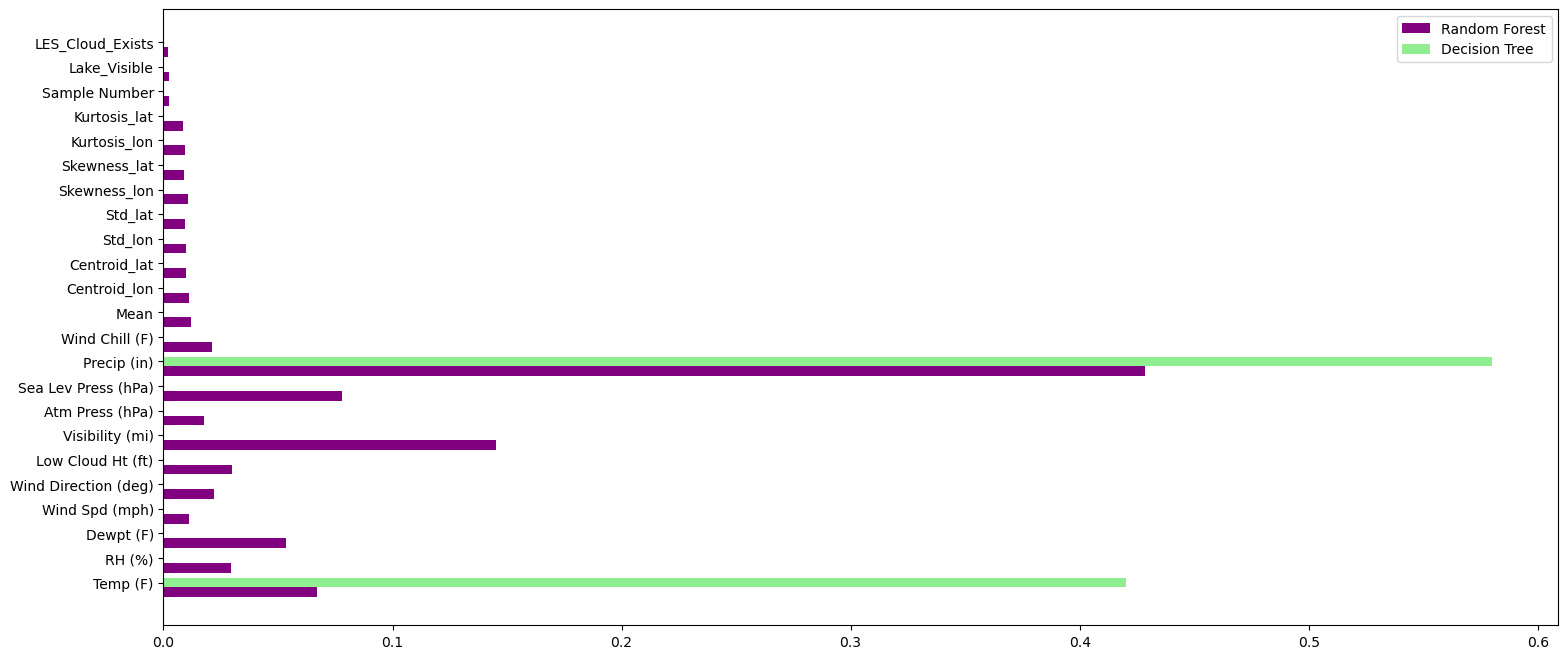

In [30]:

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance['Random_Forest'],0.4,color='purple',label='Random Forest')
dt_feature=ax.barh(index+0.4,feature_importance['dt'],0.4,color='lightgreen',label='Decision Tree')
ax.set(yticks=index+0.4,yticklabels=X_train.columns)

ax.legend()
plt.show()

## Comparison between Random Forest Classifier and Decision Tree Classifier
1. We find that Precipitation(in) is an important factor in the both cases
2. The genie impurity is calculated from Sklearn
3. The information gain is calculated from the simpleml package
4. Both parameters give similar results and helps understand the important features

## Now that we compared our model with the random forest classifier, we move on to Hyperparameter Tuning



In [31]:
dec_tree_2 = DecisionTreeClassifier()

criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12,15,20]


parameters = dict(
    criterion=criterion,
    max_depth=max_depth
)

clf_GS = GridSearchCV(
    dec_tree_2, 
    parameters,
    scoring="f1"
)
clf_GS.fit(X_train, y_train)
print(clf_GS.best_params_)

{'criterion': 'entropy', 'max_depth': 4}


1. We see that entropy is the recommended criterion
2. We also see that out of the given depths, 20 is optimal 

# Predicting occurence of snowfall over a period of time

The exact timeperiod over which we can predict is unknown, hence we simulate both models over 1 hour
1. Using the input dataset we try to predict the occurence of snowfall over a 72 hour period.
2. Results from both normal decision tree classifier and tuned decision tree classifier are compared.

In [32]:
result = []
for i in range(1, 72):
    print("Predicting for ",i," hours :")
    df2 = df.copy()
    df2['LESShift72'] = df2['LESnowfall'].shift(-i)
    df2 = df2[0:-i]
    ss = list(df)[1:-1]
    x = df2[ss]
    y = df2['LESShift72']
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

    # Create a model 
    d_model = DecisionTreeClassifier()

    # Train the model
    d_model.fit(X_train, y_train)

    print("Non Hyperparameter-Tuned Decision Tree", d_model.score(X_test, y_test))

    dec_tree_2 = DecisionTreeClassifier(
        class_weight="balanced", 
        criterion='gini', 
        max_depth=20,
        max_features=None, 
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        min_samples_leaf=1, 
        min_samples_split=2,
        min_weight_fraction_leaf=0.0, 
        random_state=None,
        splitter='best'
    )

    dec_tree_2.fit(X_train, y_train)
    
    print("Hyperparameter-Tuned Decision Tree", dec_tree_2.score(X_test, y_test))


Predicting for  1  hours :
Non Hyperparameter-Tuned Decision Tree 0.9496875
Hyperparameter-Tuned Decision Tree 0.9465625
Predicting for  2  hours :
Non Hyperparameter-Tuned Decision Tree 0.9440625
Hyperparameter-Tuned Decision Tree 0.936875
Predicting for  3  hours :
Non Hyperparameter-Tuned Decision Tree 0.945
Hyperparameter-Tuned Decision Tree 0.9290625
Predicting for  4  hours :
Non Hyperparameter-Tuned Decision Tree 0.9406064395123476
Hyperparameter-Tuned Decision Tree 0.9274773366677087
Predicting for  5  hours :
Non Hyperparameter-Tuned Decision Tree 0.9377930603313536
Hyperparameter-Tuned Decision Tree 0.899343544857768
Predicting for  6  hours :
Non Hyperparameter-Tuned Decision Tree 0.9399812441387934
Hyperparameter-Tuned Decision Tree 0.8980931541106596
Predicting for  7  hours :
Non Hyperparameter-Tuned Decision Tree 0.9327914973429197
Hyperparameter-Tuned Decision Tree 0.9084088777743045
Predicting for  8  hours :
Non Hyperparameter-Tuned Decision Tree 0.924015009380863
Hyp

Hyperparameter-Tuned Decision Tree 0.9058084772370487
Predicting for  61  hours :
Non Hyperparameter-Tuned Decision Tree 0.9158555729984301
Hyperparameter-Tuned Decision Tree 0.9086342229199372
Predicting for  62  hours :
Non Hyperparameter-Tuned Decision Tree 0.9186813186813186
Hyperparameter-Tuned Decision Tree 0.9014128728414442
Predicting for  63  hours :
Non Hyperparameter-Tuned Decision Tree 0.9237048665620095
Hyperparameter-Tuned Decision Tree 0.8916797488226059
Predicting for  64  hours :
Non Hyperparameter-Tuned Decision Tree 0.9239949748743719
Hyperparameter-Tuned Decision Tree 0.8910175879396985
Predicting for  65  hours :
Non Hyperparameter-Tuned Decision Tree 0.9224246231155779
Hyperparameter-Tuned Decision Tree 0.910175879396985
Predicting for  66  hours :
Non Hyperparameter-Tuned Decision Tree 0.9230527638190955
Hyperparameter-Tuned Decision Tree 0.8938442211055276
Predicting for  67  hours :
Non Hyperparameter-Tuned Decision Tree 0.9189698492462312
Hyperparameter-Tuned 

## Analysing the occurence of snowfall at the end of 72 hours

- With the analysis done for a time period ranging from 1 to 72 hours, we now specifically try for predicting LES for the 72nd hour using both our models

In [33]:

i = 72
print("Predicting for ",i," hours :")
df2 = df.copy()
df2['LESShift72'] = df2['LESnowfall'].shift(-i)
df2 = df2[0:-i]
ss = list(df)[1:-1]
x = df2[ss]
y = df2['LESShift72']

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=42)

# Create a model 
dec_model = DecisionTreeClassifier()

# Train the model
dec_model.fit(X_train, y_train)
y_pred = dec_model.predict(X_test)
print("\n\nDec Tree", dec_model.score(X_test, y_test))
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("Area under curve is : ",roc_auc)
print('Testing Set Evaluation F1-Score:',f1_score(y_test,dec_model.predict(X_test)))

dec_tree_2 = DecisionTreeClassifier(
    class_weight="balanced", 
    criterion='entropy', 
    max_depth=20,
    max_features=None, 
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=1, 
    min_samples_split=2,
    min_weight_fraction_leaf=0.0, 
    random_state=None,
    splitter='best'
)

dec_tree_2.fit(X_train, y_train)
y_pred = dec_tree_2.predict(X_test)
print("\n\nPipeline Model", dec_tree_2.score(X_test, y_test))
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("Area under curve is : ",roc_auc)
print('Testing Set Evaluation F1-Score:',f1_score(y_test,dec_tree_2.predict(X_test)))


Predicting for  72  hours :


Dec Tree 0.9239472030169704
R^2 :  -0.6615937009776949
MAE : 0.07605279698302954
RMSE: 0.2757767158101451
Area under curve is :  1.0
Testing Set Evaluation F1-Score: 0.2142857142857143


Pipeline Model 0.9107479572595851
R^2 :  -0.9499694672630798
MAE : 0.08925204274041483
RMSE: 0.29875080374856705
Area under curve is :  1.0
Testing Set Evaluation F1-Score: 0.26424870466321243


## Visualising our results and analysis

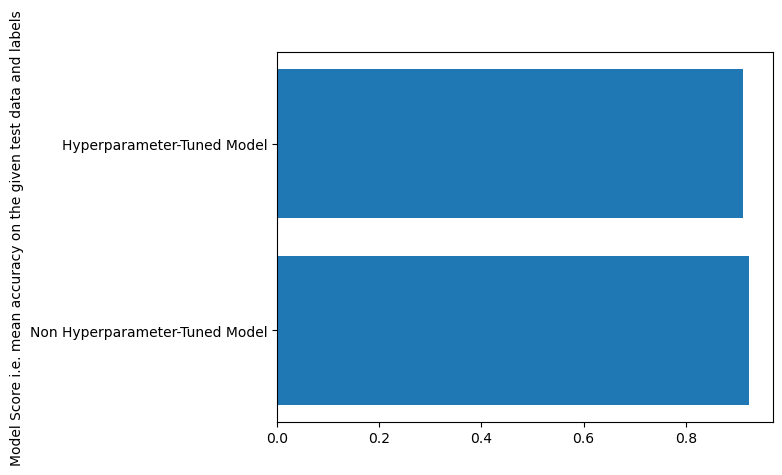

In [34]:
plt.barh(['Non Hyperparameter-Tuned Model', 'Hyperparameter-Tuned Model'], [dec_model.score(X_test, y_test), dec_tree_2.score(X_test, y_test)])
plt.ylabel('Model Score i.e. mean accuracy on the given test data and labels')
plt.show()

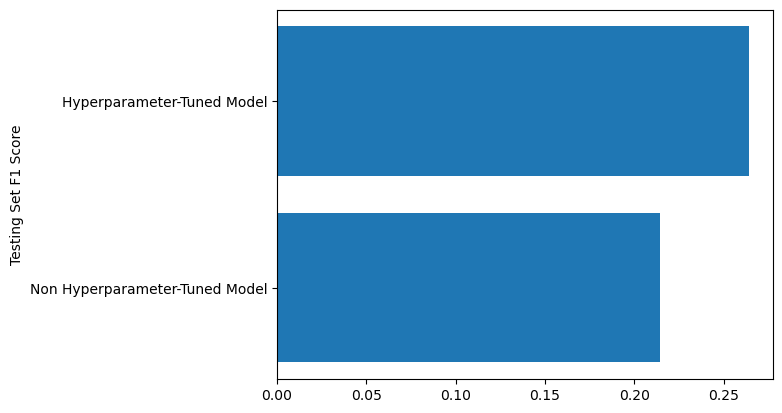

In [35]:
plt.barh(['Non Hyperparameter-Tuned Model', 'Hyperparameter-Tuned Model'], [f1_score(y_test,dec_model.predict(X_test)), f1_score(y_test,dec_tree_2.predict(X_test))])
plt.ylabel('Testing Set F1 Score')
plt.show()

## Comparing the features at the end of 72 hours
1. Analaysing feature importance of both models
2. We find that Hyperparameter Tuned Model gives a better result

    Hyperparameter-Tuned Model  Non Hyperparameter-Tuned Model
0                     0.074981                        0.042717
1                     0.052762                        0.044901
2                     0.156477                        0.055144
3                     0.034299                        0.034274
4                     0.075243                        0.066921
5                     0.057220                        0.070398
6                     0.010642                        0.022155
7                     0.050069                        0.067137
8                     0.080267                        0.056229
9                     0.012367                        0.012015
10                    0.058938                        0.053824
11                    0.051349                        0.095851
12                    0.019799                        0.056946
13                    0.046516                        0.043136
14                    0.020531                        0

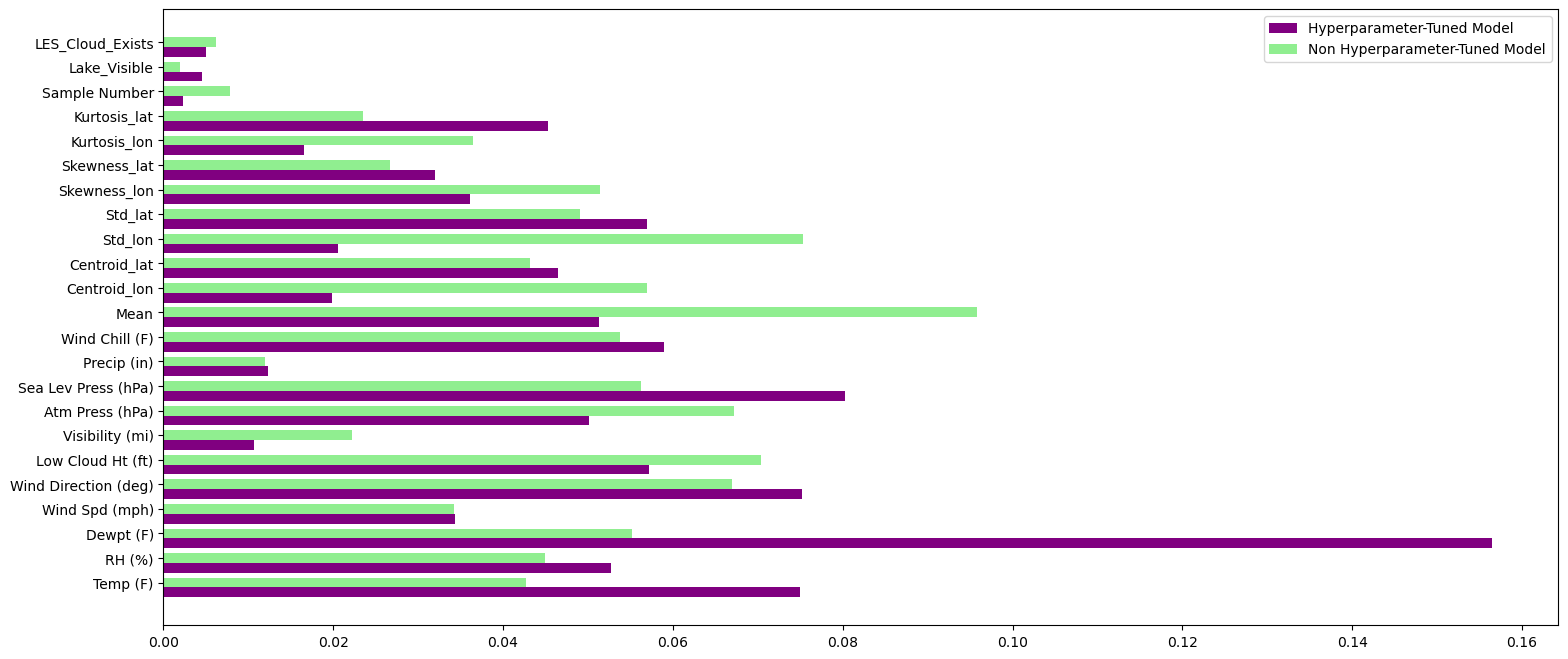

In [36]:
feature_importance=pd.DataFrame({
    'Hyperparameter-Tuned Model':dec_tree_2.feature_importances_,
    'Non Hyperparameter-Tuned Model':dec_model.feature_importances_
})

print(feature_importance)

index = np.arange(len(feature_importance))
fig, ax = plt.subplots(figsize=(18,8))
rfc_feature=ax.barh(index,feature_importance['Hyperparameter-Tuned Model'],0.4,color='purple',label='Hyperparameter-Tuned Model')
dt_feature=ax.barh(index+0.4,feature_importance['Non Hyperparameter-Tuned Model'],0.4,color='lightgreen',label='Non Hyperparameter-Tuned Model')
ax.set(yticks=index+0.4,yticklabels=X_train.columns)

ax.legend()
plt.show()

## Visualising our tree as a graph and text representation

In [37]:
from sklearn import tree
dot_data = export_graphviz(dec_tree_2, out_file=None, 
                      feature_names=ss,  
                      class_names=["Yes","No"],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [38]:
text_representation = tree.export_text(dec_tree_2)
print(text_representation)

|--- feature_2 <= 33.50
|   |--- feature_10 <= 15.34
|   |   |--- feature_8 <= 1028.75
|   |   |   |--- feature_4 <= 215.00
|   |   |   |   |--- feature_4 <= 75.00
|   |   |   |   |   |--- feature_5 <= 1050.00
|   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- feature_5 >  1050.00
|   |   |   |   |   |   |--- feature_10 <= 13.50
|   |   |   |   |   |   |   |--- feature_19 <= 1.71
|   |   |   |   |   |   |   |   |--- feature_5 <= 3050.00
|   |   |   |   |   |   |   |   |   |--- feature_6 <= 1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |--- feature_6 >  1.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |--- feature_5 >  3050.00
|   |   |   |   |   |   |   |   |   |--- feature_13 <= 43.92
|   |   |   |   |   |   |   |   |   |   |--- feature_15 <= 1.24
|   |   |   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |   |   |   |--- feature_15 >  1.24
|   |   

# Key Takeaways

1. In case of the tuned model, highest feature importance is given to DewPt
2. Whereas in case of non tuned model, Atm Press is given the highest importance
3. We get a reduced mean accuracy post tuning of 89% 
4. However, our testing set F1 score increases by 3% 
5. Thus, we can conclude that Hyper parameter tuning helps to overall improve the model. 

In [42]:
from sklearn.svm import SVC
svcclf = SVC(kernel = 'linear',gamma = 'scale', shrinking = False,)
svcclf.fit(X=X_train,y=y_train)

KeyboardInterrupt: 

In [ ]:
y_pred = svcclf.predict(X_test)
print("R^2 : ", r2_score(y_test, y_pred))
print("MAE :", mean_absolute_error(y_test,y_pred))
print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))
print("Area under curve is : ",roc_auc)
print('Testing Set Evaluation F1-Score:',f1_score(y_test,y_pred))